In [71]:
!pip install rasterstats

     |████████████████████████████████| 130 kB 8.6 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [72]:
import os
import rasterio
import rasterio.mask
from rasterio.plot import show
from shapely.geometry import mapping
from rasterstats import zonal_stats
import geopandas as gpd
import pandas as pd
import fiona
from fiona.crs import from_epsg
import matplotlib.pyplot as plt

#### Read in vector file of polygon zones

      OBJECTID           AREA  PERIMETER                             ECO_NAME  \
5073      4516  446257.777305    211.292  Interior Alaska-Yukon lowland taiga   
4951      4377  160646.465387     87.437          Brooks-British Range tundra   
5900      5170  150692.430763    163.622        Alaska-St. Elias Range tundra   
3190      2640  129977.642583     97.903              Arctic foothills tundra   
1340      2692  106590.293564     48.163             Chukchi Peninsula tundra   

     REALM  BIOME  ECO_NUM   ECO_ID  ECO_SYM  GBL_STAT  \
5073    NA    6.0      7.0  50607.0     76.0       3.0   
4951    NA   11.0      8.0  51108.0     55.0       3.0   
5900    NA   11.0      1.0  51101.0     42.0       3.0   
3190    NA   11.0      4.0  51104.0     46.0       3.0   
1340    PA   11.0      4.0  81104.0     42.0       3.0   

                              G200_REGIO  G200_NUM  G200_BIOME  G200_STAT  \
5073                                None       0.0         0.0        0.0   
4951      

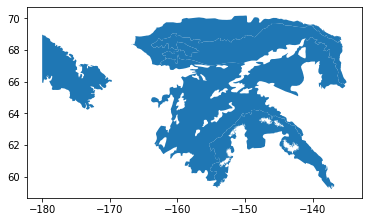

In [130]:
%%time
# Get the shp filename
shp_fn = '/att/gpfsfs/briskfs01/ppl/pmontesa/userfs02/arc/bioclimate_dd.shp'
shp_fn = '/att/gpfsfs/briskfs01/ppl/pmontesa/userfs02/data/hydrobasins/hybas_lev03_clip_above.gpkg'
shp_fn = '/projects/my-public-bucket/misc_files/hybas_lake_ar_lev08_v1c.shp'
shp_fn = '/projects/my-public-bucket/misc_files/wwf_terr_ecos.shp'

# Reading in vector and subsetting
vector_gdf = gpd.read_file(shp_fn).cx[-180:-150, 50:75]
vector_gdf.sort_values(by = 'AREA', ascending=False, inplace=True)

vector_gdf = vector_gdf.head()

print(vector_gdf)
vector_gdf.plot()
#

vector_file_name = 'bioclimate_dd'
vector_file_name = 'hybas_lev03'
vector_file_name = 'hybas_lev08'
vector_file_name = 'wwfecoregions'

zone_field_name = 'zone_'
zone_field_name = 'HYBAS_ID'
zone_field_name = 'ECO_NAME'


#### Specify raster file

In [83]:
indir = '/projects/shared-buckets/alexdevseed'
outdir = '/projects/my-public-bucket/test_output/analyze_agb'
r_fn = os.path.join(indir, 'AGB_tindex.vrt')
import rasterio.crs

with rasterio.open(r_fn, mode='r') as src:
    print(src.width, src.height)
    print(src.crs)
    print(src.indexes)
    to_crs = src.crs

360000 264000
PROJCS["unknown",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
(1, 2, 3, 4)


In [134]:
# Reproject the vector to the raster crs
in_gdf = vector_gdf.to_crs(to_crs)
in_gdf.shape

(5, 19)

<AxesSubplot:>

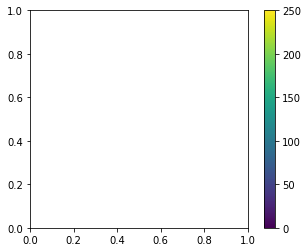

In [135]:
# Attach zonal_stats to output geodataframe
out_gdf = in_gdf.join(
    pd.DataFrame(
        zonal_stats(
            vectors=in_gdf['geometry'], 
            raster=r_fn, 
            stats=['max','mean', 'median','std','min','sum','count']
        )
    ),
    how='left'
)
out_gdf.plot('mean', cmap='viridis', legend=True, vmin=0, vmax=250)

In [141]:
out_gdf.crs


<Projected CRS: PROJCS["unknown",GEOGCS["NAD83",DATUM["North_Ameri ...>
Name: unknown
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [68]:
def get_gdf_lists(input_gdf, zone_field_name, SHOW_CLIP=False):
    '''
    From the input gdf get:
        geoms_list: the geoms (features) that you will use to clip
        zone_name_list: the names of the geoms (features)
    '''
    geoms_list = []
    zone_name_list = []

    for idx in input_gdf.index:
        #print(idx)
        geom =  input_gdf.loc[idx].geometry
        zonename =  input_gdf.loc[idx][zone_field_name]
        print(zone_field_name, zonename)
        if geom not in geoms_list:
            if SHOW_CLIP:
                gpd.GeoSeries(geom).plot()
            geoms_list.append(geom)
            zone_name_list.append(zonename)

    print(f'# of indiv features: {len(geoms_list)}')
    return [geoms_list, zone_name_list]

def do_clip(r_fn, input_gdf, zone_field_name, indir, outdir, vector_fn, SHOW_CLIP = True):
    
    geoms_list, zone_name_list = get_gdf_lists(input_gdf, zone_field_name, SHOW_CLIP = False)
    
    feature_pass_list = []
    feature_fail_list = []
    no_raster_intersection_list = []

    with rasterio.open(r_fn, "r") as r:

        for idx, zone_name in enumerate(zone_name_list):
            print(zone_name)
            geom = geoms_list[idx]
            
            feature_gdf = None
            try:
                feature_gdf = gpd.GeoDataFrame({'name':zone_name, 'geometry':geom}, crs=from_epsg(4326)) #index=[0], 
                feature_gdf.plot()
                # Reproject feature_gdf to raster crs
                feature_gdf = feature_gdf.to_crs(r.crs)
            except ValueError:
                print(f"Cant get geodataframe for feature {zone_name}")
                feature_fail_list.append(zone_name)
                
                continue

            zone_name = f'{zone_name:03}'
            out_r_fn = os.path.join(os.path.split(r_fn.replace(indir, outdir))[0] , os.path.split(r_fn)[1].replace(os.path.splitext(r_fn)[1], '_'+vector_fn+'_'+zone_name+'.tif'))

            try:

                out_image, out_transform = rasterio.mask.mask(dataset=r, shapes=feature_gdf.geometry, crop=True)

                # Copy the metadata
                out_meta = r.meta.copy()
                out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform,
                         "crs":r.crs.to_proj4()}
                                 )
                with rasterio.open(out_r_fn, "w", **out_meta) as out_r:
                    out_r.write(out_image)

                    print("Zone", zone_name, "clip of",  os.path.split(r_fn)[1])
                    print("Writing clipped subset to", out_r_fn)
                    feature_pass_list.append(zone_name)

                    #show(out_r, cmap='viridis') # <-- this show() is not working here..need to read the raster in again?

                # HERE IS WHERE WE CAN DO rasterstat's zonal_stats.
                if SHOW_CLIP:
                    show((rasterio.open(out_r_fn)), cmap='viridis')# <-- this show() works

            except ValueError:
                print(zone_name, " has no intersection with", os.path.split(r_fn)[1])
                no_raster_intersection_list.append(zone_name)
    print(f'# features that produced clips: {len(feature_pass_list)}')
    print(f'# features that failed to produce geodataframes: {len(feature_fail_list)}')
    print(f'# features that didnt have intersection with raster: {len(no_raster_intersection_list)}')

HYBAS_ID 8080000010
HYBAS_ID 8089023840
HYBAS_ID 8080000061
HYBAS_ID 8080000062
HYBAS_ID 8089051211
# of indiv features: 5
8080000010
Cant get geodataframe for feature 8080000010
8089023840
Cant get geodataframe for feature 8089023840
8080000061


/projects/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Zone 8080000061 clip of AGB_tindex.vrt
Writing clipped subset to /projects/my-public-bucket/test_output/analyze_agb/AGB_tindex_hybas_lev08_8080000061.tif


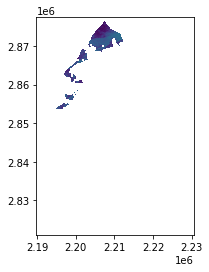

8080000062


/projects/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Zone 8080000062 clip of AGB_tindex.vrt
Writing clipped subset to /projects/my-public-bucket/test_output/analyze_agb/AGB_tindex_hybas_lev08_8080000062.tif


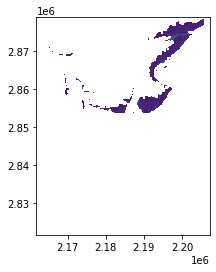

8089051211
Cant get geodataframe for feature 8089051211
# features that produced clips: 2
# features that failed to produce geodataframes: 3
# features that didnt have intersection with raster: 0


In [69]:
do_clip(r_fn, vector_gdf.head(), zone_field_name, indir, outdir, vector_file_name, SHOW_CLIP = True)